## Radiative friction force
2D simulations of electron motion in a strong magnetic field, including the Lorentz force and the radiative friction force
***

#### Definition

Electrons that experience a perpendicular external magnetic field describe a circular motion illustrated in Figure (a).
When the external magnetic field becomes large enough, electrons experience strong deflections and radiate a fraction of their energy.
This process is known as Synchrotron emission.
The electromagnetic wave emitted has a back-reaction on the electron trajectory called "radiation reaction".
This back-reaction is a radiative friction force that , denoted $\vec{F}_{\mathrm{r}}$ in Figure (b).

#### Remarks
  -  It is oriented in the direction opposite to the velocity of the electron.
  -  It is a friction force, so it decreases the energy of the electron, and slows it down.

#### Schematic representation
  -  the magnetic field $\vec{B}$ is perpendicular to the plane of the page and directed toward the reader
  -  The vector $\vec{v}$ is the velocity of the electron
  -  $\vec{F}$ is the Lorentz force induced by the magnetic field $\vec{B}$
  -  $\vec{F}_{\mathcal{r}}$ is the radiative friction force induced by the strong deflection of the electron

<img src="radiative_friction_force.png"  style="width: 900px; float: left;" />

#### Equation of motion for electron rotating in a strong magnetic field

Let's consider an electron of mass $m$ and charge $-e$. We denote $\vec{v}$ the velocity of the electron and $\vec{p}$ its momentum. We recall that for a relativistic particle $\vec{p}=m\gamma \vec{v}$, where $\gamma$ is defined as the Lorentz factor of the particle. We assume the electron evolves in a constant $\vec{B}$ field.

- The electron experiences two forces: the Lorentz force $\vec{F}$ and the radiative friction force $\vec{F}_{\mathcal{r}}$
\begin{equation*}
\frac{d \vec{p}}{dt} = \vec{F} + \vec{F}_{\mathcal{r}}
\end{equation*}

- The Lorentz force is defined as $\vec{F}=\vec{v} \times \vec{B}$.
The radiation reaction force is defined as $\vec{F}_{\mathcal{r}} = - k (\vec{v}\times\vec{B})^2 \vec{p}$

\begin{equation*}
%\frac{d \vec{p}}{dt} = -e \frac{\vec{p}}{\gamma m} \times \vec{B} - k \left(\frac{\vec{p}}{\gamma m}\times\vec{B}\right)^2 \vec{p}
\frac{d \vec{p}}{dt} = -e \vec{v} \times \vec{B} - k (\vec{v}\times\vec{B})^2 \vec{p}
\end{equation*}

#### Remarks on the radiation friction force
- Its amplitude is weak as compared to the Lorentz force. The factor k is a constant defined as $k \sim 10^{-18}$.
- Its direction is opposite to the momentum of the electron. It is a friction force slowing down the electron.


#### The simulation

In [1]:
# Add zpic library to path
import sys
sys.path.append("../../lib")

# get ZPIC 2D with radiative friction force
import em2d_rr as zpic
import numpy as np

# Time step
dt = 0.01

# Simulation time
tmax = 4*2.*np.pi

# Number of cells
nx  = [300,300]

# Simulation box size
box = [6,6]

## Plasma slab
# Particles per cell
ppc = [4,4]

# Define a custom density profile
def custom_n0(x):
    if (x>2.9 and x<3.1):
        return 1.0
    else:
        return 0.0

# Use the custom density profile
dens = zpic.Density( type = "custom", custom_x = custom_n0,custom_y = custom_n0  )

# Set up a super low density to avoid any plasma effects
dens.n=1e-6

# give it an initial momentum
ufl=100.

# Create the species
electrons = zpic.Species( "electrons", m_q=-1,ppc= ppc,
                           density = dens,ufl=[ufl,0,0])



# Initialize simulation
sim = zpic.Simulation( nx, box, dt, species = (electrons) )

#Set the sorting period to 0 in order to track the particle's trajectories 
electrons.n_sort=0

#Setup the external fields (Remember B is perpendicular to the simultion plane)
B=[0,0,100]
ext = zpic.ExternalField(B_type = 'uniform', B_0 = B)
sim.emf.set_ext_fld( ext )

#arays to store the particles trajectories
ele_part_rep =[]

while sim.t < tmax:
    print('n = {:d}, t = {:g}'.format(sim.n,sim.t), end = '\r')
    #store the electron trajectories
    ele_part_rep.append(electrons.particles[10].copy())

    sim.iter()

#### Post-processing: we extract the trajectories from simulation output

In [2]:
#convert trajectories to position arrays
e_posx_t=[(i['ix']+i['x'])*box[0]/nx[0] for i in ele_part_rep]
e_posy_t=[(i['iy']+i['y'])*box[1]/nx[1] for i in ele_part_rep]

# extract the energy of particles from the trajectories
e_gamma_t = [np.sqrt(1.0+i['ux']**2+i['uy']**2+i['uz']**2) for i in ele_part_rep]

#create time array
t=np.linspace(0,sim.t,sim.n)

Analytical solution

In [5]:
def solution(gamma0, B, t):
    ini = (gamma0 - 1.) / (gamma0 + 1.)
    k_damp = 1.1237684e-8
    tmp = -2. * k_damp * B**2 * t
    return (1. + ini * np.exp(-2. * k_damp * B**2 * t)) / (1. - ini * np.exp(-2. * k_damp * B**2 * t))

Run the next cell to plot the trajectory of the electron under the influence of these fields

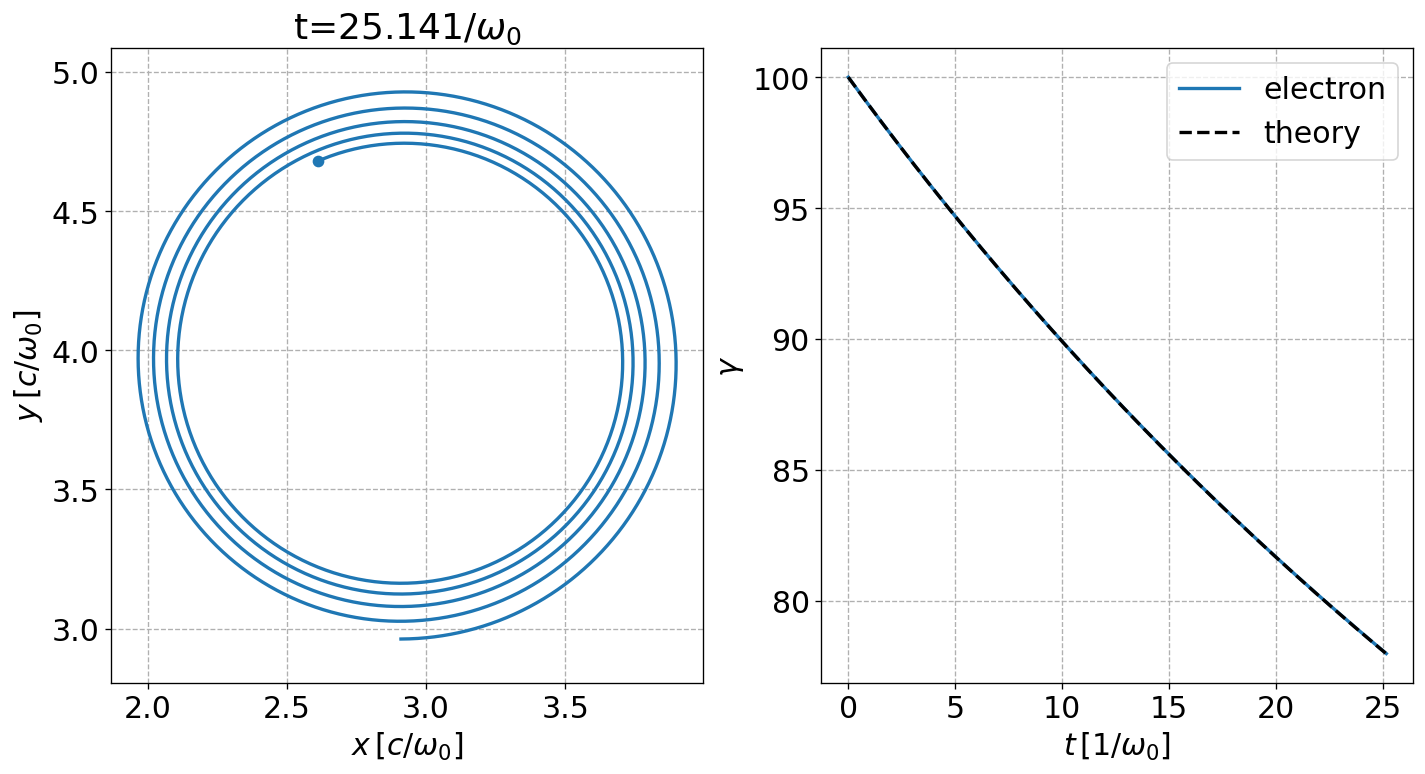

In [7]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec

#Set up the plot
fig, ax=plt.subplots(1, 2, figsize=(14, 7), dpi=120)
plt.rcParams.update({'font.size': 18})

#left part: xy trajectories

## negative charge trajectory
ax[0].plot(e_posx_t,e_posy_t,lw=2)
ax[0].scatter(e_posx_t[-1],e_posy_t[-1])

#right part: evolution of energy
ax[1].plot(t,e_gamma_t,lw=2,label="electron")
ax[1].plot(t,solution(np.sqrt(1.+ufl**2), B[2], t),lw=2,label="theory", c='k', ls='--')

##setup labels, grids, and others
ax[0].grid(True,ls="--")
ax[0].set_xlabel("$x\,[c/\omega_0]$")
ax[0].set_ylabel("$y\,[c/\omega_0]$")
ax[0].set_aspect('equal', 'datalim')
ax[0].set_title("t={:.2f}$1/\omega_0$".format(sim.t))

ax[1].grid(True,ls="--")
ax[1].set_xlabel("$t\,[1/\omega_0]$")
ax[1].set_ylabel("$\gamma$")
ax[1].legend()

plt.show()